<a href="https://colab.research.google.com/github/deckerkrogh/semeval-2024-10/blob/main/semeval_data_analysis_heuristic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#drive.mount('/content/drive')

# Publicly hosted SemEval data:
train_1_url = 'https://raw.githubusercontent.com/deckerkrogh/nlp243_data/main/datasets/task1_train.json'
train_2_url = 'https://raw.githubusercontent.com/deckerkrogh/nlp243_data/main/datasets/task2_train.json'
train_3_url = 'https://raw.githubusercontent.com/deckerkrogh/nlp243_data/main/datasets/task3_train.json'
train_2_data = pd.read_json(train_2_url)
train_3_data = pd.read_json(train_3_url)

In [4]:
#train_3_data.head()
train_2_data.head()

,episode,speakers,utterances,triggers,emotions
0,kavi.wmv,"[rosesh, sahil, indu, sahil, maya, monisha, sa...","[i hate him. i hate him mom., dad aap kyu eisa...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[anger, neutral, joy, neutral, anger, anger, n..."
1,finale.avi,"[maya, indu, maya, indu, maya, indu, maya, ind...",[indravardhan you are the limit hadd karte ho ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[disgust, anger, anger, neutral, anger, neutra..."
2,bachelor.wmv,"[indu, sahil, indu, sahil, rosesh, indu, sahil]","[ha rosesh, mila cockroach? hahahaha, are rose...","[0, 0, 0, 0, 1, 0, 0]","[neutral, neutral, anger, neutral, neutral, jo..."
3,lease1.wmv,"[monisha, sahil, monisha, sahil, monisha, sahi...","[theek se wajan karana, monisha, abhi ayi. yeh...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[neutral, neutral, anger, neutral, neutral, ne..."
4,sahillovestory.wmv,"[sahil, rosesh, sahil, rosesh, sahil, rosesh]",[mom aap aa rahi haina! so come fast i am wait...,"[0, 0, 0, 0, 1.0, 0]","[neutral, neutral, contempt, neutral, neutral,..."


In [5]:
def create_x_y(df):
    # Creates a list of feature dataframes and list of corresponding labels
    # Each element in both lists represents a conversation ("episode")

    X = []
    y = []

    for i, episode in df.iterrows():
        # Note: the emotion flip always occurs at the last utterance

        # Don't include triggers with NaN (7 of the elements in the training data)
        if None in episode["triggers"]:
            continue
        #triggers = [int(float(t)) for t in episode['triggers']]
        y.append(np.array(episode['triggers']))

        episode_df = pd.DataFrame({
            'utterance': episode['utterances'],
            'emotions': episode['emotions'],
            #'triggers': episode['triggers']
            #'emotion_flip': last_flip_i
        })

        X.append(episode_df)

    return X, y

train_X, train_y = create_x_y(train_3_data)

In [6]:
print(train_3_data["emotions"])

0                                          [joy, neutral]
1       [surprise, neutral, joy, neutral, neutral, neu...
2       [disgust, disgust, anger, neutral, neutral, su...
3                             [anger, neutral, joy, fear]
4       [neutral, joy, neutral, surprise, surprise, di...
                              ...                        
3195    [neutral, neutral, neutral, neutral, neutral, ...
3196    [neutral, neutral, neutral, surprise, neutral,...
3197    [neutral, neutral, neutral, neutral, neutral, ...
3198                         [neutral, joy, neutral, joy]
3199                             [joy, neutral, surprise]
Name: emotions, Length: 3200, dtype: object


Percent self trigger: 0.31412464766677106
Percent prev trigger: 0.6730347635452553
Percent both self and prev trigger: 0.11368618853742563
Previous trigger distribution across emotions: {'neutral': 0.6883116883116883, 'joy': 0.6547811993517018, 'fear': 0.6, 'disgust': 0.6456692913385826, 'surprise': 0.74375, 'sadness': 0.5838709677419355, 'anger': 0.6780045351473923}
Self trigger distribution across emotions: {'neutral': 0.23191094619666047, 'joy': 0.37763371150729336, 'fear': 0.42857142857142855, 'disgust': 0.4015748031496063, 'surprise': 0.21666666666666667, 'sadness': 0.5, 'anger': 0.3401360544217687}


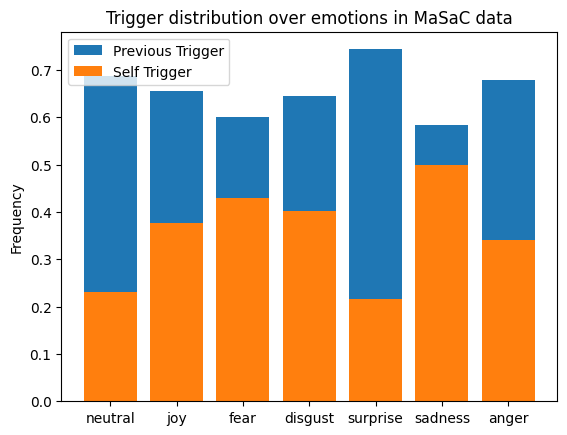

In [13]:
# NOTE: 'contempt' only used in MaSaC dataset
emotions = ['neutral', 'joy', 'fear', 'disgust', 'surprise', 'sadness', 'anger']

emotion_distrib = {e: 0 for e in emotions}
prev_trigger_distrib = {e: 0 for e in emotions}
self_trigger_distrib = {e: 0 for e in emotions}

num_self_trigger = 0
num_prev_trigger = 0
num_both_trigger = 0
for X, y in zip(train_X, train_y):
    target_emotion = X['emotions'].tolist()[-1]
    emotion_distrib[target_emotion] += 1
    if y[-1] == 1:
        num_self_trigger += 1
        self_trigger_distrib[target_emotion] += 1
    if len(y) <= 1:
        continue
    if y[-2] == 1:
        num_prev_trigger += 1
        prev_trigger_distrib[target_emotion] += 1
    if y[-1] == 1.0 and y[-2] == 1.0:
        num_both_trigger += 1

prev_trigger_distrib = {e: f / emotion_distrib[e] for e, f in prev_trigger_distrib.items()}
self_trigger_distrib = {e: f / emotion_distrib[e] for e, f in self_trigger_distrib.items()}
print(f"Percent self trigger: {num_self_trigger/len(train_y)}")
print(f"Percent prev trigger: {num_prev_trigger/len(train_y)}")
print(f"Percent both self and prev trigger: {num_both_trigger/len(train_y)}")

fig, ax = plt.subplots()
ax.bar(*zip(*prev_trigger_distrib.items()))
ax.bar(*zip(*self_trigger_distrib.items()))
ax.legend(['Previous Trigger','Self Trigger'],loc='upper left')
ax.set_ylabel('Frequency')
ax.set_title('Trigger distribution over emotions in MaSaC data')
print(f'Previous trigger distribution across emotions: {prev_trigger_distrib}')
print(f'Self trigger distribution across emotions: {self_trigger_distrib}')
plt.show()


In [7]:

def self_trigger_heur(episode):
    a = np.zeros(len(episode))
    a[-1] = 1.0
    return a

def prev_trigger_heur(episode):
    a = np.zeros(len(episode))
    a[-2] = 1.0
    return a

def eval(y_pred, y):
    scores = []
    for a,b in zip(y_pred,y):
        scores += mean_squared_error(a,b)
    scores = [f1_score(a, b) for a, b in zip(y_pred, y)]
    score = sum(scores) / len(scores)
    return score

y_pred = [prev_trigger_heur(episode) for episode in train_X]
print(f'score: {eval(y_pred, train_y)}')

score: 0.5765821904719534
